In [1]:
import OpenImageIO as oiio
import numpy as np
import matplotlib.pyplot as plt

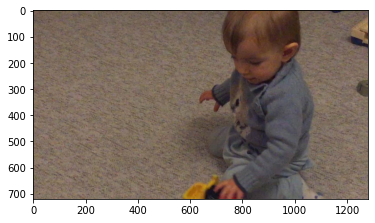

(1280, 720)

In [2]:
# Read image file with OIIO.ImageBufer

import OpenImageIO as oiio
from pathlib import Path

image_path = Path("./tests/resources/MASA_sequence/MASA_sequence_00196.jpg")
# image_path = Path("./tests/resources/EF_VFX_04/EF_VFX_04_0094901.dpx")
assert image_path.exists()
image = oiio.ImageBuf(str(image_path))
pixels = image.get_pixels().astype(np.float32)
import matplotlib.pyplot as plt

plt.imshow(pixels)
plt.show()

width, height = image.spec().width, image.spec().height
width, height

In [3]:
# Get video metadata
import cv2
from pathlib import Path

path = "./tests/resources/Mása - becsukjuk, nem latszik.mp4"
assert Path(path).exists()

cap = cv2.VideoCapture(path)
width = int( cap.get(cv2.CAP_PROP_FRAME_WIDTH) )
height = int( cap.get(cv2.CAP_PROP_FRAME_HEIGHT) )

width, height

(1280, 720)

1.13s


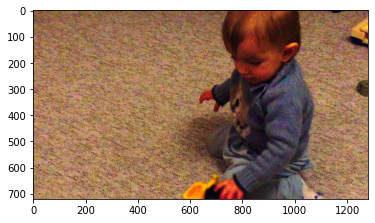

In [6]:
# apply lut with naive python
from numba import jit, njit, prange
import time

@jit(nopython=True)
def apply_lut(pixels, lut):
    dst = np.zeros(pixels.shape)
    for i in prange( pixels.shape[1]*pixels.shape[0] ):
        x = i%pixels.shape[1]
        y = i//pixels.shape[1]

        # get src color
        r,g,b = pixels[y,x]

        # lookup color
        ri = r*lut.shape[0]
        gi = g*lut.shape[1]
        bi = b*lut.shape[2]
        if ri>31:
            ri=31
        if gi>31:
            gi=31
        if bi>31:
            bi=31

        colored = lut[int(bi),int(gi),int(ri)]
        
        # dst[y,x] = (pixels[y,x][0], pixels[y,x][1], pixels[y,x][2]*0)
        dst[y,x] = colored

    return dst

begin = time.time()
dst = apply_lut(pixels, lut)
end = time.time()

dt = end-begin
print("{:.2f}s".format(dt))
plt.imshow(dst)
plt.show()

In [7]:
# Create Cube LUT Interpolator for numpy
assert lut.shape[0]==lut.shape[1]==lut.shape[2] and lut.shape[3]==3

# lut values
rlut = lut[:,:,:,0].copy(order='C')
glut = lut[:,:,:,1].copy(order='C')
blut = lut[:,:,:,2].copy(order='C')

# th.copy(order='C')e grid coordinates
x = np.linspace(0,1,32)
y = np.linspace(0,1,32)
z = np.linspace(0,1,32)
xyz = np.array([x,y,z])

from scipy.interpolate import RegularGridInterpolator

interpolator_red = RegularGridInterpolator(xyz, rlut, method='linear')
interpolator_green = RegularGridInterpolator(xyz, glut, method='linear')
interpolator_blue = RegularGridInterpolator(xyz, blut, method='linear')

xyz.shape

(3, 32)

1.5021483898162842


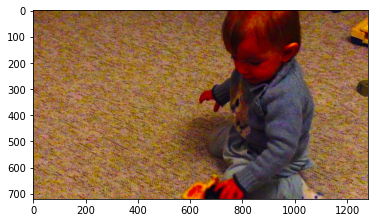

In [8]:
# Apply lut to each channel
import cv2
import time
assert len(pixels.shape)==3 and pixels.shape[2]==3

begin = time.time()
# interpolate each channel on each RGB grids
method = 'nearest'
r = interpolator_red(pixels)
g = interpolator_green(pixels)
b = interpolator_blue(pixels)
# r = interpn(xyz, rlut, pixels, method=method)
# g = interpn(xyz, glut, pixels, method=method)
# b = interpn(xyz, blut, pixels, method=method)

# concatenate final values
rgbs = cv2.merge([b,g,r])
end = time.time()
dt = end-begin
print(dt)
plt.imshow(rgbs)
plt.show()



In [10]:
# create interp3d
from scipy.interpolate import interp_3d
interp_red = interp_3d.Interp3D(rlut, x,y,z)
interp_green = interp_3d.Interp3D(glut, x,y,z)
interp_blue = interp_3d.Interp3D(blut, x,y,z)

# apply lut
interp_red( pixels )

ImportError: cannot import name 'interp_3d' from 'scipy.interpolate' (C:\Users\andris\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\interpolate\__init__.py)

In [11]:
from interp3d import interp_3d

import numpy as np

x = np.linspace(0,2.5,100)
y = np.linspace(-1,.5,50)
z = np.linspace(5,25,125)

X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
arr = X+2*Y-3*Z

interp = interp_3d.Interp3D(arr, x,y,z)

from scipy.interpolate import RegularGridInterpolator
interp_si = RegularGridInterpolator((x,y,z),arr)

x0, y0, z0 = (1.1,0.25, 7.5)
print('this class {}'.format(interp((x0,y0,z0))))
print('scipy.interpolate.RegularGridInterpolator() {}'.format(interp_si((x0,y0,z0)), x0+2*y0-3*z0))
print('exact {}'.format(x0+2*y0-3*z0))

this class -20.9
scipy.interpolate.RegularGridInterpolator() -20.9
exact -20.9


AssertionError: 

In [5]:
%load_ext Cython

In [14]:
%%cython
import numpy as np
cimport numpy as np
from cython cimport boundscheck, wraparound, nonecheck, cdivision
from libc.math cimport floor, ceil, round

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

# @boundscheck(False)
# @wraparound(False)
# @nonecheck(False)
def apply_lut(np.ndarray[DTYPE_t, ndim=3] pixels, np.ndarray[DTYPE_t, ndim=4] lut):
    cdef int h = pixels.shape[0]
    cdef int w = pixels.shape[1]
    cdef int c = pixels.shape[2]
    cdef int i, x, y, ri, gi, bi, count
    cdef DTYPE_t r,g,b
    cdef np.ndarray[DTYPE_t, ndim=3] dst

    dst = np.empty( (h,w,c), dtype=np.float32 )
    count = pixels.shape[1]*pixels.shape[0]
    for i in range( count ):
        x = i%pixels.shape[1]
        y = i//pixels.shape[1]

        # get src color
        r = pixels[y,x,0]
        g = pixels[y,x,1]
        b = pixels[y,x,2]

        # lookup color
        ri = int(r*lut.shape[0])
        gi = int(g*lut.shape[1])
        bi = int(b*lut.shape[2])
        if ri>31:
            ri=31
        if gi>31:
            gi=31
        if bi>31:
            bi=31

        dst[y,x][0] = lut[bi, gi, ri, 0]
        dst[y,x][1] = lut[bi, gi, ri, 1]
        dst[y,x][2] = lut[bi, gi, ri, 2]

    return dst




pixels: float32
lut:    float32
0.66s


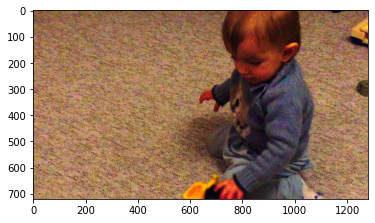

In [15]:
begin = time.time()
print("pixels:", pixels.dtype)
print("lut:   ", lut.dtype)
dst = apply_lut(pixels, lut)
end = time.time()

dt = end-begin
print("{:.2f}s".format(dt))
plt.imshow(dst)
plt.show()

In [6]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport floor
from cython cimport boundscheck, wraparound, nonecheck, cdivision

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

@boundscheck(False)
@wraparound(False)
@nonecheck(False)
def interp3D(DTYPE_t[:,:,::1] v, DTYPE_t[:,:,::1] xs, DTYPE_t[:,:,::1] ys, DTYPE_t[:,:,::1] zs):

    cdef int X, Y, Z
    X,Y,Z = v.shape[0], v.shape[1], v.shape[2]
    cdef np.ndarray[DTYPE_t, ndim=3] interpolated = np.zeros((X, Y, Z), dtype=DTYPE)

    _interp3D(&v[0,0,0], &xs[0,0,0], &ys[0,0,0], &zs[0,0,0], &interpolated[0,0,0], X, Y, Z)
    return interpolated


@cdivision(True)
cdef inline void _interp3D(DTYPE_t *v, DTYPE_t *x_points, DTYPE_t *y_points, DTYPE_t *z_points, 
               DTYPE_t *result, int X, int Y, int Z):

    cdef:
        int i, x0, x1, y0, y1, z0, z1, dim
        DTYPE_t x, y, z, xd, yd, zd, c00, c01, c10, c11, c0, c1, c

    dim = X*Y*Z

    for i in range(dim):
        x = x_points[i]
        y = y_points[i]
        z = z_points[i]

        x0 = <int>floor(x)
        x1 = x0 + 1
        y0 = <int>floor(y)
        y1 = y0 + 1
        z0 = <int>floor(z)
        z1 = z0 + 1

        xd = (x-x0)/(x1-x0)
        yd = (y-y0)/(y1-y0)
        zd = (z-z0)/(z1-z0)

        if x0 >= 0 and y0 >= 0 and z0 >= 0:
            c00 = v[Y*Z*x0+Z*y0+z0]*(1-xd) + v[Y*Z*x1+Z*y0+z0]*xd
            c01 = v[Y*Z*x0+Z*y0+z1]*(1-xd) + v[Y*Z*x1+Z*y0+z1]*xd
            c10 = v[Y*Z*x0+Z*y1+z0]*(1-xd) + v[Y*Z*x1+Z*y1+z0]*xd
            c11 = v[Y*Z*x0+Z*y1+z1]*(1-xd) + v[Y*Z*x1+Z*y1+z1]*xd

            c0 = c00*(1-yd) + c10*yd
            c1 = c01*(1-yd) + c11*yd

            c = c0*(1-zd) + c1*zd

        else:
            c = 0

        result[i] = c 

In [7]:
rlut = lut[:,:,:,0].copy(order='C').astype(np.float32)
print(rlut.shape)
xs = np.array([[[0.5, 0.5, 0.5]]], dtype=np.float32)
ys = xs.copy()
zs = ys.copy()
print(rlut.shape)
print(xs.shape)
interp3D(rlut, xs, ys, zs)